In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
import os  # 确保导入os模块

In [2]:
# 数据加载和预处理
data = pd.read_excel('data/CO2_20250208.xlsx', sheet_name='CO2 solubility data')

In [3]:
data.head(8)

,No.,IL,x_CO2 (mol/kg sorbent),T (K),P (bar),IF1,IF2,IF3,IF4,IF5,...,IF35,IF36,IF37,IF38,IF39,IF40,IF41,IF42,IF43,IF44
0,1,[Bis(mim)C2][Gly]2,0.8504,313.15,0.1154,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,[Bis(mim)C2][Gly]2,1.1442,313.15,0.2692,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,[Bis(mim)C2][Gly]2,1.4535,313.15,0.5385,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,[Bis(mim)C2][Gly]2,2.3503,313.15,0.8462,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,[Bis(mim)C2][Gly]2,2.4895,313.15,1.3077,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,[Bis(mim)C2][Gly]2,2.5823,313.15,1.7308,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,[Bis(mim)C2][Gly]2,2.6132,313.15,2.0000,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,[Bis(mim)C2][Gly]2,2.6441,313.15,2.9615,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(data.shape)

(2500, 49)


In [5]:
exclude =['No.','IL']
y='x_CO2 (mol/kg sorbent)'
features = [var for var in data.columns if var not in exclude+[y]]
print(len(features), len(exclude))

46 2


In [6]:
data = data.fillna(0)

In [7]:
data[features].info(show_counts = True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 46 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T (K)    2500 non-null   float64
 1   P (bar)  2500 non-null   float64
 2   IF1      2500 non-null   int64  
 3   IF2      2500 non-null   int64  
 4   IF3      2500 non-null   int64  
 5   IF4      2500 non-null   int64  
 6   IF5      2500 non-null   int64  
 7   IF6      2500 non-null   int64  
 8   IF7      2500 non-null   int64  
 9   IF8      2500 non-null   int64  
 10  IF9      2500 non-null   int64  
 11  IF10     2500 non-null   int64  
 12  IF11     2500 non-null   int64  
 13  IF12     2500 non-null   int64  
 14  IF13     2500 non-null   int64  
 15  IF14     2500 non-null   int64  
 16  IF15     2500 non-null   int64  
 17  IF16     2500 non-null   int64  
 18  IF17     2500 non-null   int64  
 19  IF18     2500 non-null   int64  
 20  IF19     2500 non-null   int64  
 21  IF20     2500 

In [8]:
single_var =[]
for var in features:
    print(var, "----",len(data[var].unique()),data[var].unique()) 
    if len(data[var].unique())==1:
        single_var.append(var)

T (K) ---- 48 [313.15 293.15 303.15 323.15 298.2  298.1  298.   298.3  288.15 298.15
 308.15 318.15 303.16 313.28 313.31 323.32 323.34 333.35 333.36 333.41
 353.55 353.18 295.15 283.1  323.1  348.1  348.2  310.15 333.15 343.15
 303.2  313.2  323.2  343.2  353.2  328.15 338.15 333.2  295.12 353.15
 296.15 373.15 393.15 308.   318.   328.   338.   283.15]
P (bar) ---- 1112 [0.1154 0.2692 0.5385 ... 0.234  0.239  0.419 ]
IF1 ---- 4 [ 2  1  0 10]
IF2 ---- 2 [0 1]
IF3 ---- 3 [0 2 1]
IF4 ---- 2 [0 1]
IF5 ---- 2 [0 1]
IF6 ---- 5 [ 0  1  2  3 10]
IF7 ---- 2 [0 1]
IF8 ---- 2 [0 1]
IF9 ---- 2 [0 1]
IF10 ---- 4 [0 3 2 1]
IF11 ---- 2 [0 1]
IF12 ---- 3 [0 2 1]
IF13 ---- 3 [0 1 2]
IF14 ---- 2 [0 1]
IF15 ---- 11 [ 2  4  5  3 20  1  6  8 12  7 40]
IF16 ---- 32 [  4   2   6   3   5   7   8   1  25  11  14   0  10  31  29  30  32  20
  26  21  12  24  22  33  17  13  16  28 295  58  57  56]
IF17 ---- 3 [0 1 2]
IF18 ---- 2 [0 1]
IF19 ---- 2 [0 1]
IF20 ---- 3 [0 2 1]
IF21 ---- 2 [0 1]
IF22 ---- 14 [ 6 12 

In [9]:
single_var

[]

In [10]:
# 确保只使用数值特征
use_features = [var for var in features if data[var].dtype in ['int64', 'float64']]

print(f"使用的特征数量: {len(use_features)}")
print(f"特征列表: {use_features}")

使用的特征数量: 46
特征列表: ['T (K)', 'P (bar)', 'IF1', 'IF2', 'IF3', 'IF4', 'IF5', 'IF6', 'IF7', 'IF8', 'IF9', 'IF10', 'IF11', 'IF12', 'IF13', 'IF14', 'IF15', 'IF16', 'IF17', 'IF18', 'IF19', 'IF20', 'IF21', 'IF22', 'IF23', 'IF24', 'IF25', 'IF26', 'IF27', 'IF28', 'IF29', 'IF30', 'IF31', 'IF32', 'IF33', 'IF34', 'IF35', 'IF36', 'IF37', 'IF38', 'IF39', 'IF40', 'IF41', 'IF42', 'IF43', 'IF44']


In [11]:
# 分割数据
X_train, X_test, y_train, y_test = train_test_split(
    data[use_features], data[y], test_size=0.2, random_state=512
)

print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")

训练集形状: (2000, 46), 测试集形状: (500, 46)


In [12]:
X_train

,T (K),P (bar),IF1,IF2,IF3,IF4,IF5,IF6,IF7,IF8,...,IF35,IF36,IF37,IF38,IF39,IF40,IF41,IF42,IF43,IF44
268,288.15,3.5000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
229,298.10,6.9990,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1891,308.00,1.0000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1647,373.15,0.5920,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
398,308.15,0.1830,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,308.15,1.5000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2305,303.15,0.7870,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1181,313.15,7.2286,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
360,298.10,0.5040,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
single_var

[]

In [14]:
# 检查数据中是否还有非数值值
print("\n检查数据类型:")
print(X_train.dtypes)



检查数据类型:
T (K)      float64
P (bar)    float64
IF1          int64
IF2          int64
IF3          int64
IF4          int64
IF5          int64
IF6          int64
IF7          int64
IF8          int64
IF9          int64
IF10         int64
IF11         int64
IF12         int64
IF13         int64
IF14         int64
IF15         int64
IF16         int64
IF17         int64
IF18         int64
IF19         int64
IF20         int64
IF21         int64
IF22         int64
IF23         int64
IF24         int64
IF25         int64
IF26         int64
IF27         int64
IF28         int64
IF29         int64
IF30         int64
IF31         int64
IF32         int64
IF33         int64
IF34         int64
IF35         int64
IF36         int64
IF37         int64
IF38         int64
IF39         int64
IF40         int64
IF41         int64
IF42         int64
IF43         int64
IF44         int64
dtype: object


In [15]:
# 设置全局样式
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

In [16]:
# 1. 定义评估函数
def evaluate_model_full(model, X_train, y_train, X_test, y_test):
    """
    评估模型在训练集和测试集上的各种指标
    """
    # 训练集预测和评估
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_aard = 100 * np.mean(np.abs((y_train - y_train_pred) / np.clip(np.abs(y_train), 1e-10, None)))
    
    # 测试集预测和评估
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_aard = 100 * np.mean(np.abs((y_test - y_test_pred) / np.clip(np.abs(y_test), 1e-10, None)))
    
    return {
        'train': {
            'R2': train_r2, 
            'MAE': train_mae, 
            'MSE': train_mse, 
            'RMSE': train_rmse, 
            'AARD%': train_aard
        },
        'test': {
            'R2': test_r2, 
            'MAE': test_mae, 
            'MSE': test_mse, 
            'RMSE': test_rmse, 
            'AARD%': test_aard
        },
        'predictions': {
            'y_train_pred': y_train_pred,
            'y_test_pred': y_test_pred
        }
    }


In [17]:
# 2. 定义不同激活函数的参数分布
param_distributions = {
    'relu': {
        'mlp__hidden_layer_sizes': [(i, j) for i in range(10, 111, 5) for j in range(10, 111, 5)],
        'mlp__alpha': loguniform(1e-5, 1e-1),
        'mlp__learning_rate_init': loguniform(1e-4, 1e-1),
        'mlp__batch_size': [32, 64, 128, 256]
    },
    'logistic': {
        'mlp__hidden_layer_sizes': [(i, j) for i in range(10, 111, 5) for j in range(10, 111, 5)],
        'mlp__alpha': loguniform(1e-5, 1e-1),
        'mlp__learning_rate_init': loguniform(1e-4, 1e-1),
        'mlp__batch_size': [32, 64, 128, 256]
    },
    'tanh': {
        'mlp__hidden_layer_sizes': [(i, j) for i in range(10, 111, 5) for j in range(10, 111, 5)],
        'mlp__alpha': loguniform(1e-5, 1e-1),
        'mlp__learning_rate_init': loguniform(1e-4, 1e-1),
        'mlp__batch_size': [32, 64, 128, 256]
    },
    'identity': {
        'mlp__hidden_layer_sizes': [(i, j) for i in range(10, 111, 5) for j in range(10, 111, 5)],
        'mlp__alpha': loguniform(1e-5, 1e-1),
        'mlp__learning_rate_init': loguniform(1e-4, 1e-1),
        'mlp__batch_size': [32, 64, 128, 256]
    }
}

# 初始化结果存储
results = {}
best_models = {}


In [18]:
# 3. 对每种激活函数进行随机搜索
activations = ['relu', 'logistic', 'tanh', 'identity']

for activation in activations:
    print(f"\n正在训练 {activation.upper()} 激活函数...")
    start_time = time.time()
    
    # 创建pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            activation=activation,
            hidden_layer_sizes=None,  # 设为None，完全由随机搜索参数决定
            max_iter=1000,
            random_state=42,
            early_stopping=False,
            validation_fraction=0.1
        ))
    ])
    
    # 随机搜索
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions[activation],
        n_iter=100,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=512,
        pre_dispatch='2*n_jobs'
    )
    
    try:
        # 在训练集上拟合随机搜索
        random_search.fit(X_train, y_train)
        
        # 存储最佳模型和其交叉验证分数
        best_model = random_search.best_estimator_
        best_cv_score = -random_search.best_score_
        best_params = random_search.best_params_
        
        print(f"Best CV MSE for {activation}: {best_cv_score:.4f}")
        print(f"Best Parameters: {best_params}")
        
        # 用最佳模型在训练集和测试集上进行评估
        full_metrics = evaluate_model_full(best_model, X_train, y_train, X_test, y_test)
        
        # 存储所有结果
        results[activation] = {
            'best_model': best_model,
            'best_cv_score': best_cv_score,
            'best_params': best_params,
            'train_metrics': full_metrics['train'],
            'test_metrics': full_metrics['test'],
            'predictions': full_metrics['predictions']
        }
        
        best_models[activation] = best_model
        
        end_time = time.time()
        print(f"{activation.upper()} 激活函数训练完成，耗时: {end_time - start_time:.2f} 秒")
        
    except Exception as e:
        print(f"训练 {activation} 激活函数时出错: {e}")
        import traceback
        traceback.print_exc()
        continue


正在训练 RELU 激活函数...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best CV MSE for relu: 0.2023
Best Parameters: {'mlp__alpha': 0.023958622242817303, 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (65, 60), 'mlp__learning_rate_init': 0.008786070599150143}
RELU 激活函数训练完成，耗时: 204.78 秒

正在训练 LOGISTIC 激活函数...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best CV MSE for logistic: 0.2043
Best Parameters: {'mlp__alpha': 0.0002185548829509445, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (110, 10), 'mlp__learning_rate_init': 0.0018131243145466684}
LOGISTIC 激活函数训练完成，耗时: 451.47 秒

正在训练 TANH 激活函数...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best CV MSE for tanh: 0.2194
Best Parameters: {'mlp__alpha': 0.0006249958210447859, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (70, 40), 'mlp__learning_rate_init': 0.002899417963369715}
TANH 激活函数训练完成，耗时: 313.12 秒

正在训练 IDENTITY 激活函数...
Fitting 5 folds for each of 100 candidates, totalling 50

In [19]:
# 4. 汇总并比较所有模型在训练集和测试集上的性能
if results:
    print("\n" + "="*80)
    print("FINAL COMPARISON - TRAINING SET PERFORMANCE")
    print("="*80)
    
    # 训练集性能比较
    train_comparison_df = pd.DataFrame()
    for activation_name, res in results.items():
        train_metrics = res['train_metrics']
        train_comparison_df[activation_name] = pd.Series(train_metrics)
    
    train_comparison_df = train_comparison_df.T
    print("训练集性能:")
    print(train_comparison_df.round(4))
    
    print("\n" + "="*80)
    print("FINAL COMPARISON - TEST SET PERFORMANCE")
    print("="*80)
    
    # 测试集性能比较
    test_comparison_df = pd.DataFrame()
    for activation_name, res in results.items():
        test_metrics = res['test_metrics']
        test_comparison_df[activation_name] = pd.Series(test_metrics)
    
    test_comparison_df = test_comparison_df.T
    print("测试集性能:")
    print(test_comparison_df.round(4))
    


FINAL COMPARISON - TRAINING SET PERFORMANCE
训练集性能:
              R2     MAE     MSE    RMSE     AARD%
relu      0.9334  0.1967  0.0975  0.3122   29.8929
logistic  0.9301  0.1909  0.1023  0.3198   31.7995
tanh      0.9321  0.1807  0.0994  0.3153   39.6505
identity  0.4420  0.6054  0.8166  0.9036  134.3129

FINAL COMPARISON - TEST SET PERFORMANCE
测试集性能:
              R2     MAE     MSE    RMSE     AARD%
relu      0.8191  0.2621  0.2495  0.4995   38.3311
logistic  0.8084  0.2633  0.2642  0.5140   36.8485
tanh      0.8495  0.2403  0.2075  0.4555   43.1605
identity  0.3974  0.6393  0.8311  0.9116  112.6054


In [20]:
    # 5. 输出各个激活函数的最佳参数
    print("\n" + "="*80)
    print("BEST PARAMETERS FOR EACH ACTIVATION FUNCTION")
    print("="*80)
    
    for activation_name, res in results.items():
        print(f"\n{activation_name.upper()} Activation Best Parameters:")
        for param_name, param_value in res['best_params'].items():
            clean_param_name = param_name.replace('mlp__', '')
            print(f"  {clean_param_name}: {param_value}")
    


BEST PARAMETERS FOR EACH ACTIVATION FUNCTION

RELU Activation Best Parameters:
  alpha: 0.023958622242817303
  batch_size: 128
  hidden_layer_sizes: (65, 60)
  learning_rate_init: 0.008786070599150143

LOGISTIC Activation Best Parameters:
  alpha: 0.0002185548829509445
  batch_size: 32
  hidden_layer_sizes: (110, 10)
  learning_rate_init: 0.0018131243145466684

TANH Activation Best Parameters:
  alpha: 0.0006249958210447859
  batch_size: 256
  hidden_layer_sizes: (70, 40)
  learning_rate_init: 0.002899417963369715

IDENTITY Activation Best Parameters:
  alpha: 2.6185922438658532e-05
  batch_size: 32
  hidden_layer_sizes: (105, 60)
  learning_rate_init: 0.00013974158698336442


In [21]:
    # 6. 根据测试集性能选择最佳模型
    print("\n" + "="*80)
    print("BEST MODEL SELECTION (BASED ON TEST SET)")
    print("="*80)
    
    if 'R2' in test_comparison_df.columns:
        best_activation_by_r2 = test_comparison_df['R2'].idxmax()
        print(f"Best activation based on R²: {best_activation_by_r2}")
        print(f"Test R²: {test_comparison_df.loc[best_activation_by_r2, 'R2']:.4f}")
        print(f"Train R²: {train_comparison_df.loc[best_activation_by_r2, 'R2']:.4f}")
    
    if 'AARD%' in test_comparison_df.columns:
        best_activation_by_aard = test_comparison_df['AARD%'].idxmin()
        print(f"\nBest activation based on AARD%: {best_activation_by_aard}")
        print(f"Test AARD%: {test_comparison_df.loc[best_activation_by_aard, 'AARD%']:.2f}%")
        print(f"Train AARD%: {train_comparison_df.loc[best_activation_by_aard, 'AARD%']:.2f}%")



BEST MODEL SELECTION (BASED ON TEST SET)
Best activation based on R²: tanh
Test R²: 0.8495
Train R²: 0.9321

Best activation based on AARD%: logistic
Test AARD%: 36.85%
Train AARD%: 31.80%


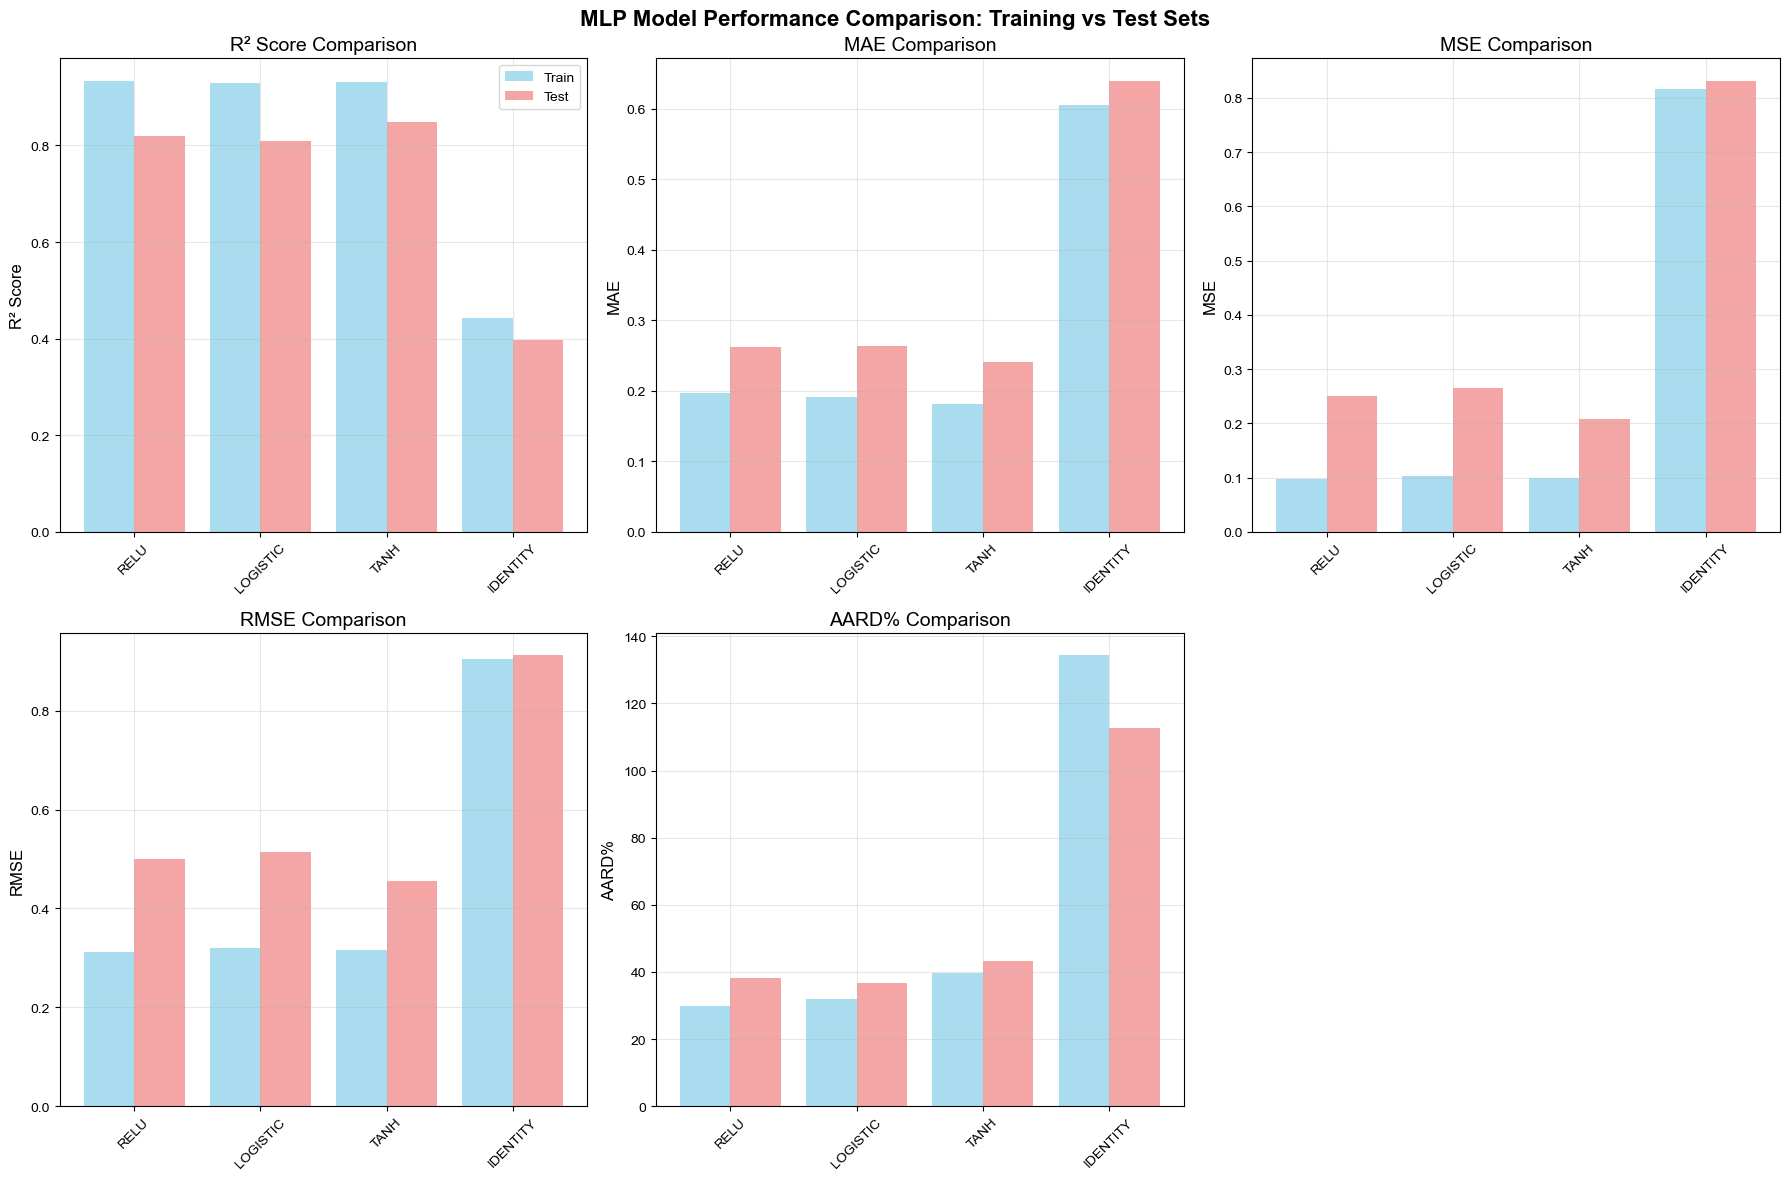

MLP模型性能比较可视化完成！


In [22]:
# 7. 可视化比较结果
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MLP Model Performance Comparison: Training vs Test Sets', fontsize=16, fontweight='bold')

model_names = list(results.keys())
metrics_info = [
    ('R2', 'R² Score', 'R² Score Comparison'),
    ('MAE', 'MAE', 'MAE Comparison'),
    ('MSE', 'MSE', 'MSE Comparison'),
    ('RMSE', 'RMSE', 'RMSE Comparison'),
    ('AARD%', 'AARD%', 'AARD% Comparison')
]

for i, (metric, ylabel, title) in enumerate(metrics_info):
    row = i // 3
    col = i % 3
    
    # 所有子图使用相同的颜色
    axes[row, col].bar([x - 0.2 for x in range(len(results))], train_comparison_df[metric], 
                      width=0.4, alpha=0.7, label='Train' if i == 0 else "", color='skyblue')
    axes[row, col].bar([x + 0.2 for x in range(len(results))], test_comparison_df[metric], 
                      width=0.4, alpha=0.7, label='Test' if i == 0 else "", color='lightcoral')
    
    axes[row, col].set_title(title, fontname='Arial', fontsize=14)
    axes[row, col].set_ylabel(ylabel, fontname='Arial', fontsize=12)
    axes[row, col].set_xticks(range(len(results)))
    axes[row, col].set_xticklabels([act.upper() for act in model_names], rotation=45, fontname='Arial')
    axes[row, col].grid(True, alpha=0.3)
    
    # 只在第一个子图显示图例
    if i == 0:
        axes[row, col].legend(prop={'family': 'Arial'})

# 隐藏第六个子图
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('mlp_model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("MLP模型性能比较可视化完成！")


GENERATING VISUALIZATIONS FOR EACH ACTIVATION FUNCTION

生成 RELU 激活函数的可视化图表


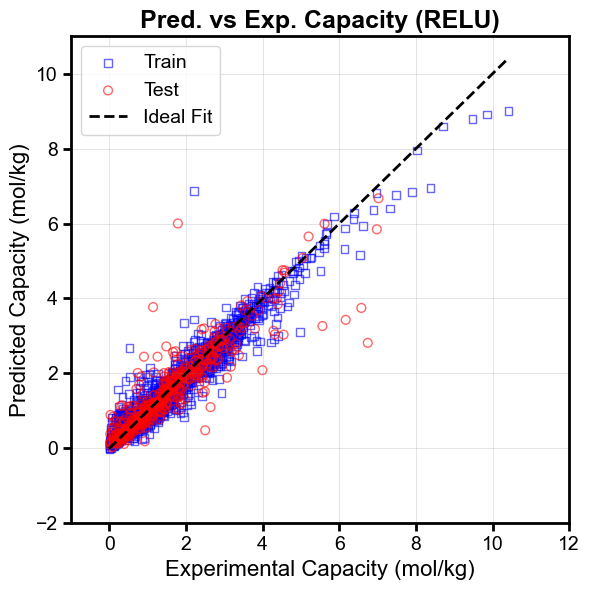

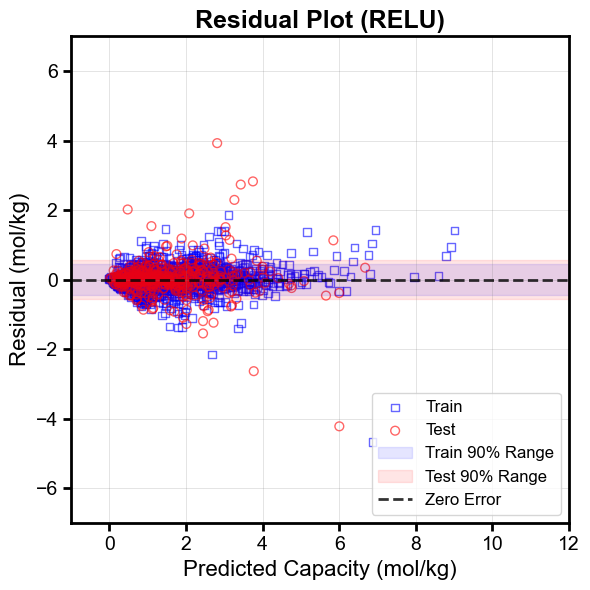

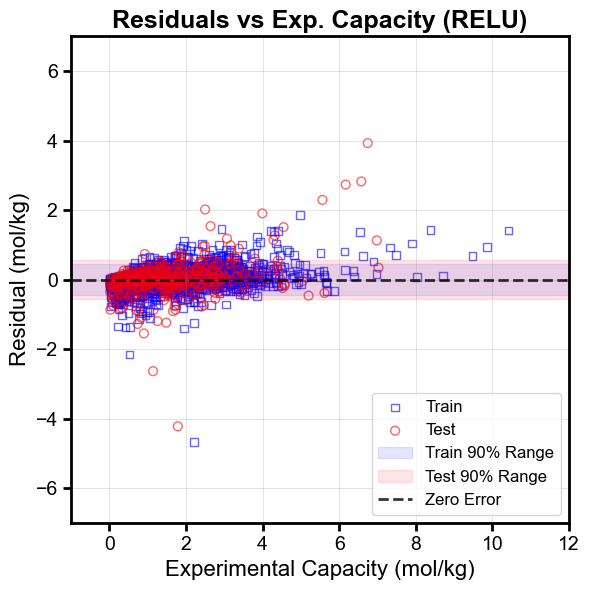

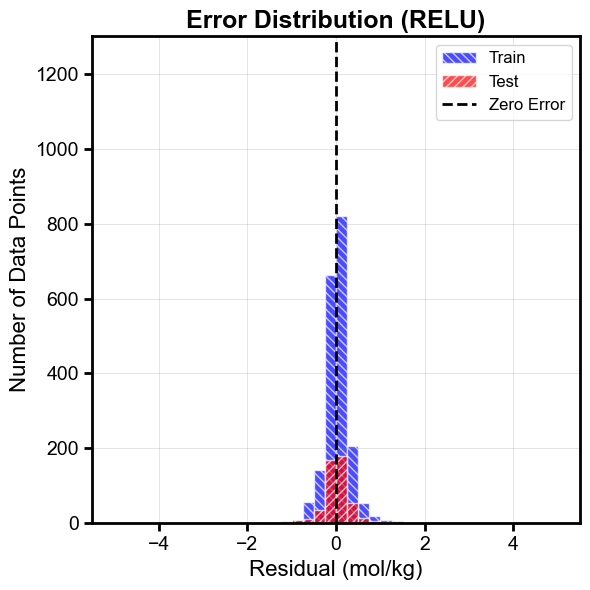

RELU 模型详细统计信息
最佳参数: {'mlp__alpha': 0.023958622242817303, 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (65, 60), 'mlp__learning_rate_init': 0.008786070599150143}
训练集R²: 0.9334
测试集R²: 0.8191
训练集MAE: 0.1967 mol/kg
测试集MAE: 0.2621 mol/kg
训练集RMSE: 0.3122 mol/kg
测试集RMSE: 0.4995 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-0.4351, 0.4623] mol/kg
测试集: 90.0% 在 [-0.5501, 0.5704] mol/kg

📊 残差统计:
训练集残差均值: 0.0259 mol/kg
测试集残差均值: 0.0344 mol/kg
训练集残差标准差: 0.3112 mol/kg
测试集残差标准差: 0.4989 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 1483/2000 数据点 (74.2%)
测试集: 350/500 数据点 (70.0%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.1080 mol/kg

生成 LOGISTIC 激活函数的可视化图表


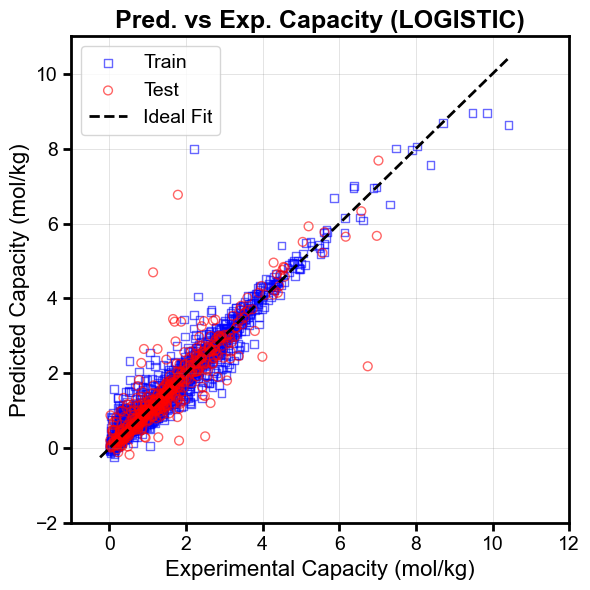

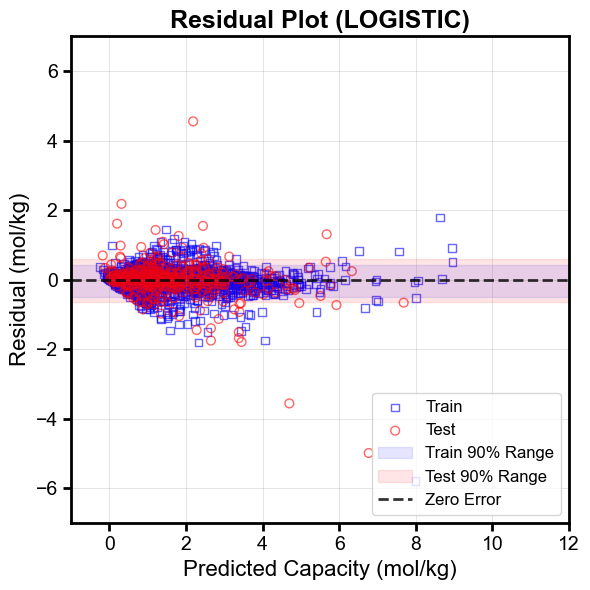

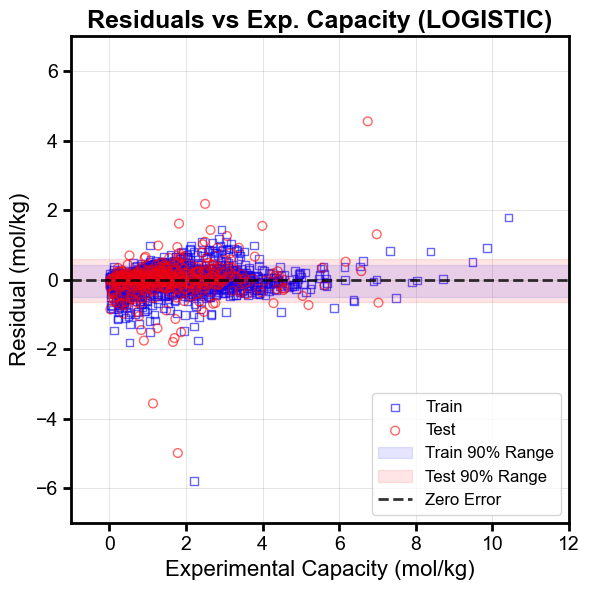

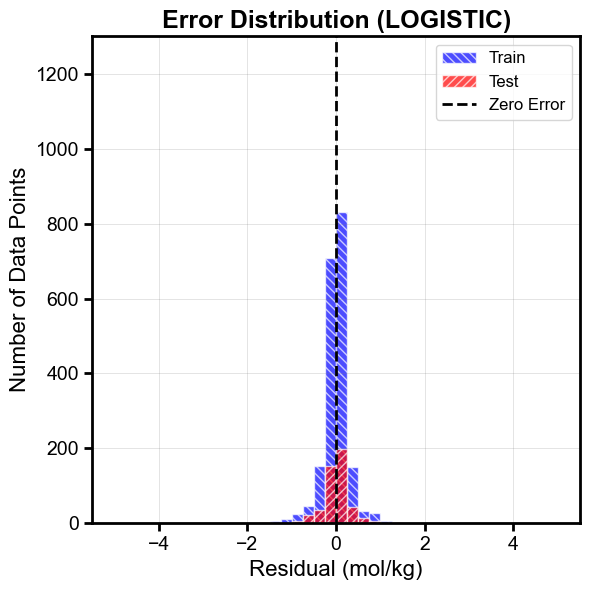

LOGISTIC 模型详细统计信息
最佳参数: {'mlp__alpha': 0.0002185548829509445, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (110, 10), 'mlp__learning_rate_init': 0.0018131243145466684}
训练集R²: 0.9301
测试集R²: 0.8084
训练集MAE: 0.1909 mol/kg
测试集MAE: 0.2633 mol/kg
训练集RMSE: 0.3198 mol/kg
测试集RMSE: 0.5140 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-0.4825, 0.4130] mol/kg
测试集: 90.0% 在 [-0.6474, 0.5864] mol/kg

📊 残差统计:
训练集残差均值: -0.0102 mol/kg
测试集残差均值: -0.0011 mol/kg
训练集残差标准差: 0.3197 mol/kg
测试集残差标准差: 0.5145 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 1538/2000 数据点 (76.9%)
测试集: 353/500 数据点 (70.6%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.1649 mol/kg

生成 TANH 激活函数的可视化图表


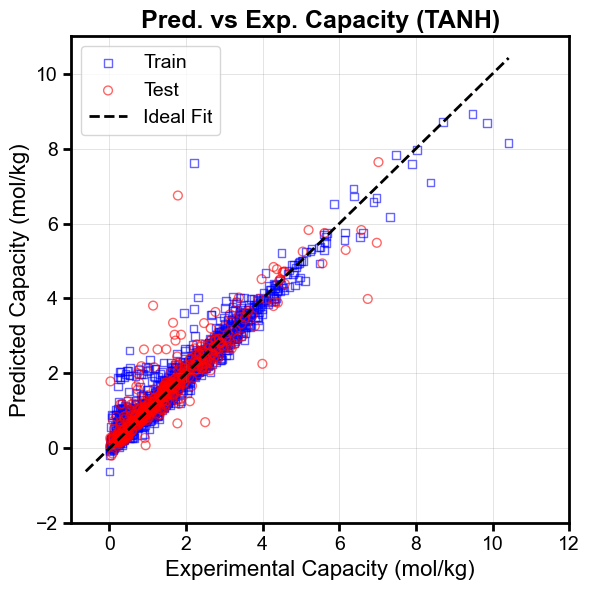

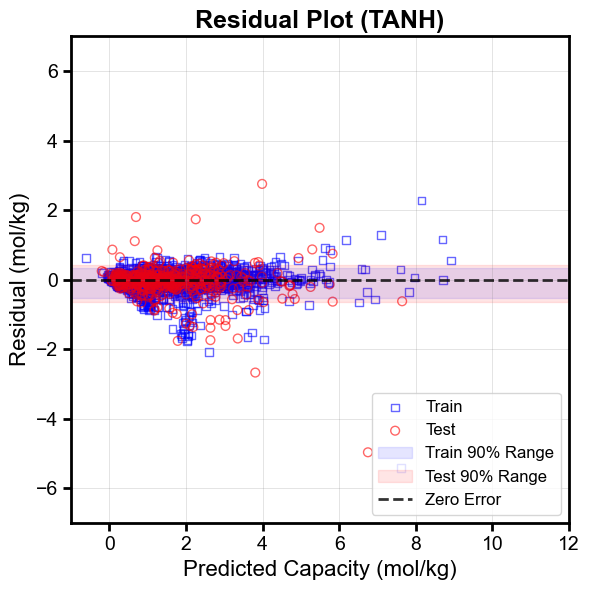

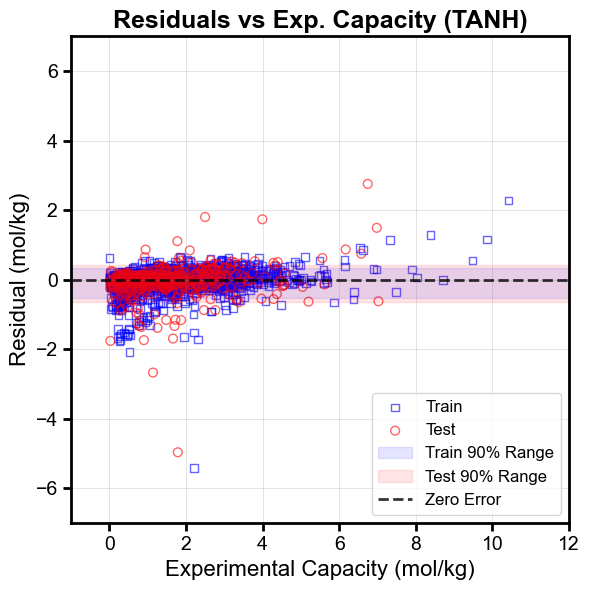

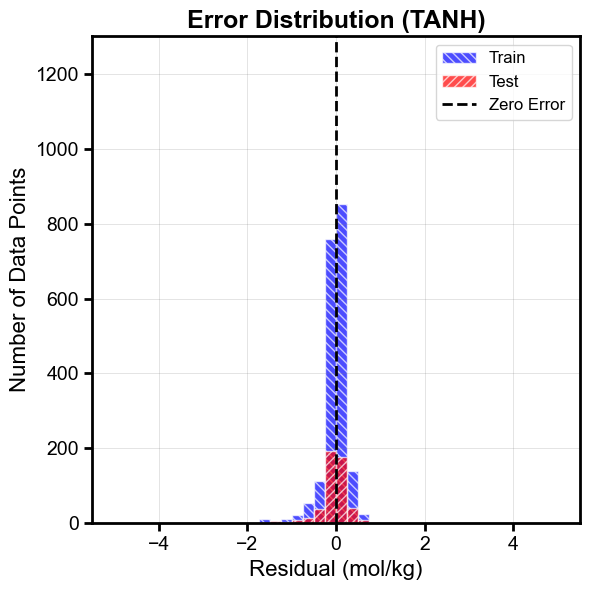

TANH 模型详细统计信息
最佳参数: {'mlp__alpha': 0.0006249958210447859, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (70, 40), 'mlp__learning_rate_init': 0.002899417963369715}
训练集R²: 0.9321
测试集R²: 0.8495
训练集MAE: 0.1807 mol/kg
测试集MAE: 0.2403 mol/kg
训练集RMSE: 0.3153 mol/kg
测试集RMSE: 0.4555 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-0.5228, 0.3300] mol/kg
测试集: 90.0% 在 [-0.6307, 0.4142] mol/kg

📊 残差统计:
训练集残差均值: -0.0304 mol/kg
测试集残差均值: -0.0493 mol/kg
训练集残差标准差: 0.3139 mol/kg
测试集残差标准差: 0.4533 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 1610/2000 数据点 (80.5%)
测试集: 369/500 数据点 (73.8%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.1080 mol/kg

生成 IDENTITY 激活函数的可视化图表


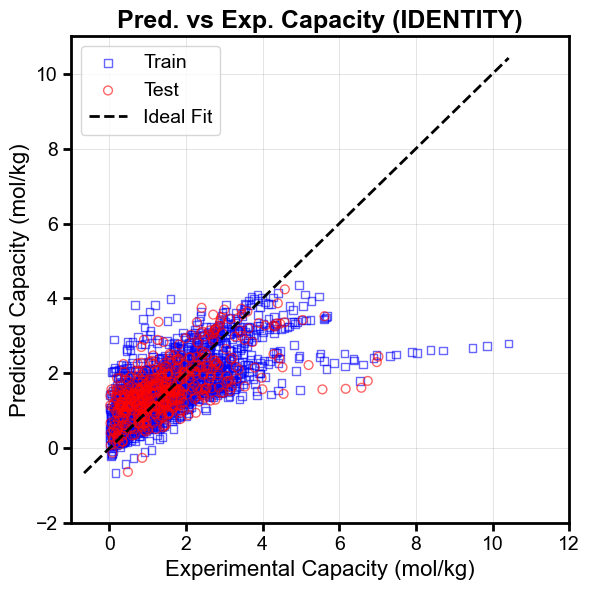

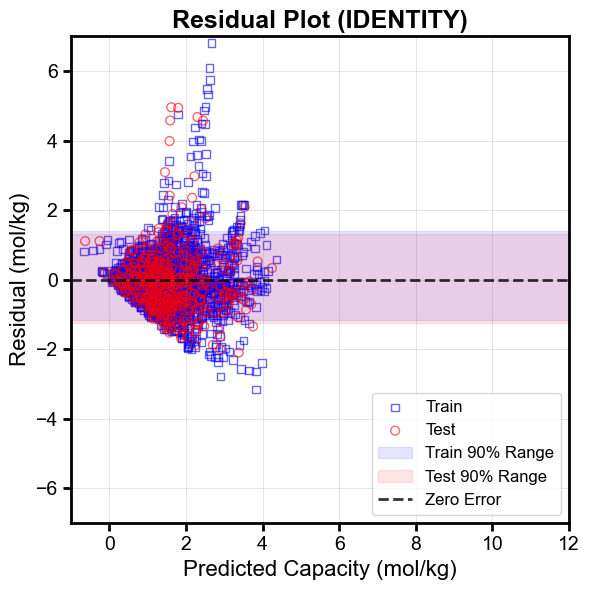

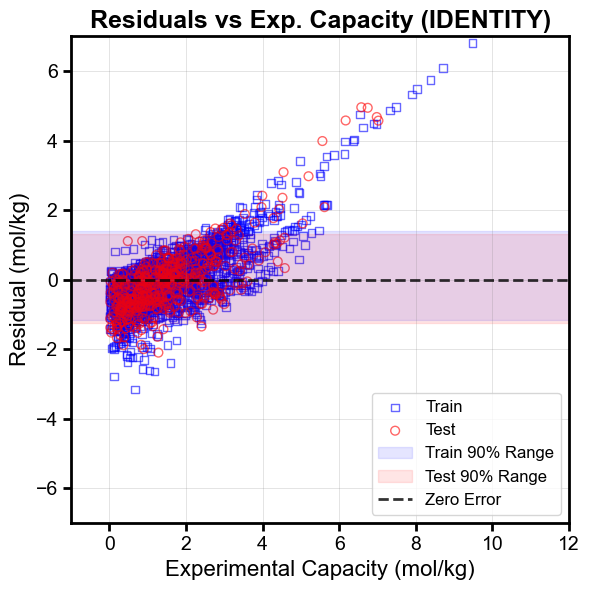

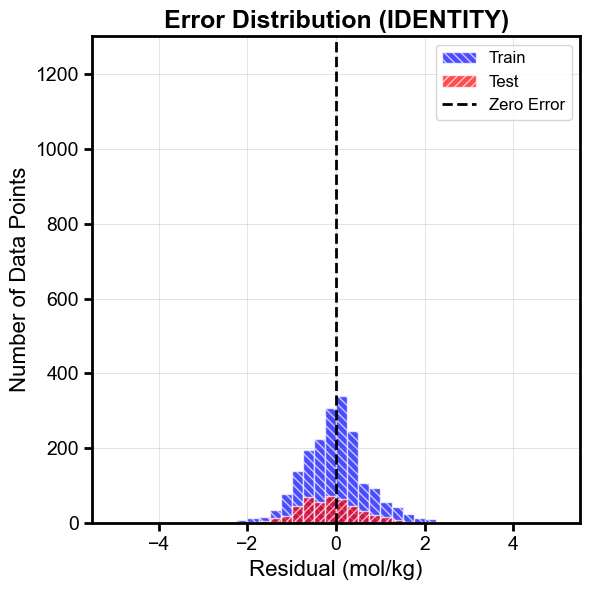

IDENTITY 模型详细统计信息
最佳参数: {'mlp__alpha': 2.6185922438658532e-05, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (105, 60), 'mlp__learning_rate_init': 0.00013974158698336442}
训练集R²: 0.4420
测试集R²: 0.3974
训练集MAE: 0.6054 mol/kg
测试集MAE: 0.6393 mol/kg
训练集RMSE: 0.9036 mol/kg
测试集RMSE: 0.9116 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-1.1487, 1.3982] mol/kg
测试集: 90.0% 在 [-1.2453, 1.3121] mol/kg

📊 残差统计:
训练集残差均值: 0.0161 mol/kg
测试集残差均值: -0.0475 mol/kg
训练集残差标准差: 0.9037 mol/kg
测试集残差标准差: 0.9113 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 648/2000 数据点 (32.4%)
测试集: 139/500 数据点 (27.8%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.0860 mol/kg

MLP模型训练和评估完成！


In [23]:
# 8. 定义可视化评估函数
def calculate_90_percent_range(errors):
    """计算90%数据点落入的残差范围"""
    lower_bound = np.percentile(errors, 5)
    upper_bound = np.percentile(errors, 95)
    in_range = np.sum((errors >= lower_bound) & (errors <= upper_bound))
    total = len(errors)
    percentage = (in_range / total) * 100
    return lower_bound, upper_bound, percentage

def plot_mlp_evaluation(activation_name, model_info, X_train, y_train, X_test, y_test, best_params):
    """为每个激活函数模型生成四种可视化图表"""
    
    # 获取预测值
    y_train_pred = model_info['predictions']['y_train_pred']
    y_test_pred = model_info['predictions']['y_test_pred']
    
    # 计算误差
    train_errors = y_train - y_train_pred
    test_errors = y_test - y_test_pred
    
    # 计算90%范围
    train_lower, train_upper, train_percentage = calculate_90_percent_range(train_errors)
    test_lower, test_upper, test_percentage = calculate_90_percent_range(test_errors)
    
    # 计算误差在[-0.25, 0.25]范围内的百分比
    def calculate_error_in_range(errors, lower_bound, upper_bound):
        in_range = np.sum((errors >= lower_bound) & (errors <= upper_bound))
        percentage = (in_range / len(errors)) * 100
        return in_range, percentage
    
    train_in_025, train_percent_025 = calculate_error_in_range(train_errors, -0.25, 0.25)
    test_in_025, test_percent_025 = calculate_error_in_range(test_errors, -0.25, 0.25)
    
    # 设置全局样式参数
    border_width = 2.0
    tick_fontsize = 14
    label_fontsize = 16
    title_fontsize = 18
    tick_width = 2.0
    tick_length = 6
    
    # 1. 预测值与真实值对比图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    plt.scatter(y_train, y_train_pred, color='none', edgecolor='blue', 
               alpha=0.6, s=30, label="Train", linewidth=1, marker='s')
    plt.scatter(y_test, y_test_pred, color='none', edgecolor='red', 
               alpha=0.6, s=40, label="Test", linewidth=1, marker='o')
    
    min_val = min(min(y_train), min(y_test), min(y_train_pred), min(y_test_pred))
    max_val = max(max(y_train), max(y_test), max(y_train_pred), max(y_test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='black', 
             linestyle='--', linewidth=2, label='Ideal Fit')
    
    plt.ylim(-2, 11)
    plt.xlim(-1, 12)
    
    plt.xlabel("Experimental Capacity (mol/kg)", fontsize=label_fontsize, fontname='Arial')
    plt.ylabel("Predicted Capacity (mol/kg)", fontsize=label_fontsize, fontname='Arial')
    plt.title(f"Pred. vs Exp. Capacity ({activation_name.upper()})", fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='upper left', prop={'family': 'Arial', 'size': 14})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontsize=tick_fontsize, fontname='Arial')
    plt.yticks(fontsize=tick_fontsize, fontname='Arial')
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 2. 残差 vs 预测值图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    plt.scatter(y_train_pred, train_errors, alpha=0.6, s=30, color='none', 
                edgecolor='blue', linewidth=1, label='Train', marker='s')
    plt.scatter(y_test_pred, test_errors, alpha=0.6, s=40, color='none', 
                edgecolor='red', linewidth=1, label='Test', marker='o')
    
    plt.axhspan(train_lower, train_upper, alpha=0.1, color='blue', label='Train 90% Range')
    plt.axhspan(test_lower, test_upper, alpha=0.1, color='red', label='Test 90% Range')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Zero Error')
    
    plt.ylim(-7, 7)
    plt.xlim(-1, 12)
    
    plt.xlabel('Predicted Capacity (mol/kg)', fontsize=label_fontsize, fontname='Arial')
    plt.ylabel('Residual (mol/kg)', fontsize=label_fontsize, fontname='Arial')
    plt.title(f'Residual Plot ({activation_name.upper()})', fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='lower right', prop={'family': 'Arial', 'size': 12})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontsize=tick_fontsize, fontname='Arial')
    plt.yticks(fontsize=tick_fontsize, fontname='Arial')
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 3. 残差 vs 实验值图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    plt.scatter(y_train, train_errors, alpha=0.6, s=30, color='none', 
                edgecolor='blue', linewidth=1, label='Train', marker='s')
    plt.scatter(y_test, test_errors, alpha=0.6, s=40, color='none', 
                edgecolor='red', linewidth=1, label='Test', marker='o')
    
    plt.axhspan(train_lower, train_upper, alpha=0.1, color='blue', label='Train 90% Range')
    plt.axhspan(test_lower, test_upper, alpha=0.1, color='red', label='Test 90% Range')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Zero Error')
    
    plt.ylim(-7, 7)
    plt.xlim(-1, 12)
    
    plt.xlabel('Experimental Capacity (mol/kg)', fontsize=label_fontsize, fontname='Arial')
    plt.ylabel('Residual (mol/kg)', fontsize=label_fontsize, fontname='Arial')
    plt.title(f'Residuals vs Exp. Capacity ({activation_name.upper()})', fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='lower right', prop={'family': 'Arial', 'size': 12})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontsize=tick_fontsize, fontname='Arial')
    plt.yticks(fontsize=tick_fontsize, fontname='Arial')
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 4. 误差分布图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    # 按照0.25为间隔的区间划分
    bin_edges = []
    current = 0
    max_error = max(np.abs(train_errors.max()), np.abs(test_errors.max()))
    
    while current <= max_error + 0.25:
        bin_edges.extend([-current - 0.25, -current])
        if current != 0:
            bin_edges.extend([current, current + 0.25])
        current += 0.25
    
    bin_edges = sorted(set(bin_edges))
    
    plt.hist(train_errors, bins=bin_edges, alpha=0.7, color='blue', 
             edgecolor='white', label='Train', density=False, hatch='\\\\\\\\')
    plt.hist(test_errors, bins=bin_edges, alpha=0.7, color='red', 
             edgecolor='white', label='Test', density=False, hatch='////')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
    
    plt.ylim(0, 1300)
    plt.xlim(-5.5, 5.5)
    
    plt.xlabel('Residual (mol/kg)', fontsize=label_fontsize, fontname='Arial')
    plt.ylabel('Number of Data Points', fontsize=label_fontsize, fontname='Arial')
    plt.title(f'Error Distribution ({activation_name.upper()})', fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='upper right', prop={'family': 'Arial', 'size': 12})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontsize=tick_fontsize, fontname='Arial')
    plt.yticks(fontsize=tick_fontsize, fontname='Arial')
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 打印详细的统计信息
    print("="*80)
    print(f"{activation_name.upper()} 模型详细统计信息")
    print("="*80)
    
    train_metrics = model_info['train_metrics']
    test_metrics = model_info['test_metrics']
    
    print(f"最佳参数: {best_params}")
    print(f"训练集R²: {train_metrics['R2']:.4f}")
    print(f"测试集R²: {test_metrics['R2']:.4f}")
    print(f"训练集MAE: {train_metrics['MAE']:.4f} mol/kg")
    print(f"测试集MAE: {test_metrics['MAE']:.4f} mol/kg")
    print(f"训练集RMSE: {train_metrics['RMSE']:.4f} mol/kg")
    print(f"测试集RMSE: {test_metrics['RMSE']:.4f} mol/kg")
    
    print(f"\n📊 残差分析 - 90%数据点范围:")
    print(f"训练集: {train_percentage:.1f}% 在 [{train_lower:.4f}, {train_upper:.4f}] mol/kg")
    print(f"测试集: {test_percentage:.1f}% 在 [{test_lower:.4f}, {test_upper:.4f}] mol/kg")
    
    print(f"\n📊 残差统计:")
    print(f"训练集残差均值: {train_errors.mean():.4f} mol/kg")
    print(f"测试集残差均值: {test_errors.mean():.4f} mol/kg")
    print(f"训练集残差标准差: {train_errors.std():.4f} mol/kg")
    print(f"测试集残差标准差: {test_errors.std():.4f} mol/kg")
    
    print(f"\n📊 误差在[-0.25, 0.25]范围内:")
    print(f"训练集: {train_in_025}/{len(train_errors)} 数据点 ({train_percent_025:.1f}%)")
    print(f"测试集: {test_in_025}/{len(test_errors)} 数据点 ({test_percent_025:.1f}%)")
    
    print(f"\n📊 模型性能评估:")
    max_train_error = max(abs(train_lower), abs(train_upper))
    max_test_error = max(abs(test_lower), abs(test_upper))
    
    if max_test_error < 0.1:
        print("✅ 优秀: 90%预测误差 < 0.1 mol/kg")
    elif max_test_error < 0.2:
        print("👍 良好: 90%预测误差 < 0.2 mol/kg")
    elif max_test_error < 0.3:
        print("⚠️ 一般: 90%预测误差 < 0.3 mol/kg")
    else:
        print("❌ 需要改进: 预测误差较大")
    
    print(f"过拟合程度: {abs(max_train_error - max_test_error):.4f} mol/kg")

# 9. 为每个激活函数生成可视化图表
if results:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS FOR EACH ACTIVATION FUNCTION")
    print("="*80)
    
    for activation_name, model_info in results.items():
        print(f"\n{'='*80}")
        print(f"生成 {activation_name.upper()} 激活函数的可视化图表")
        print(f"{'='*80}")
        
        plot_mlp_evaluation(
            activation_name=activation_name,
            model_info=model_info,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            best_params=model_info['best_params']
        )

print("\nMLP模型训练和评估完成！")


GENERATING VISUALIZATIONS FOR EACH ACTIVATION FUNCTION

生成 RELU 激活函数的可视化图表


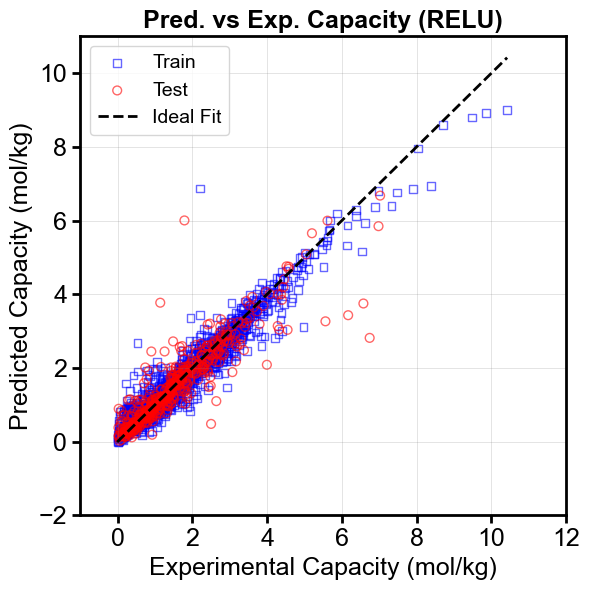

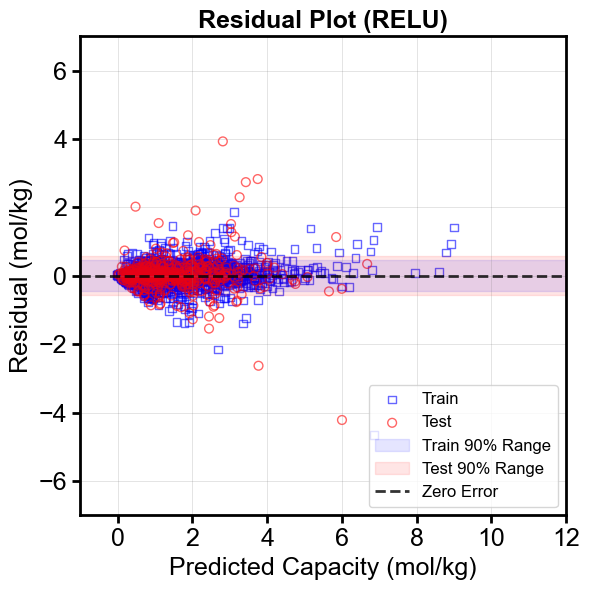

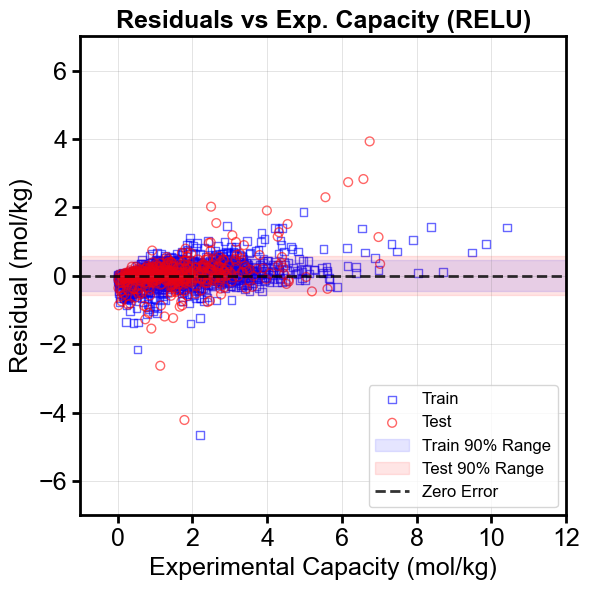

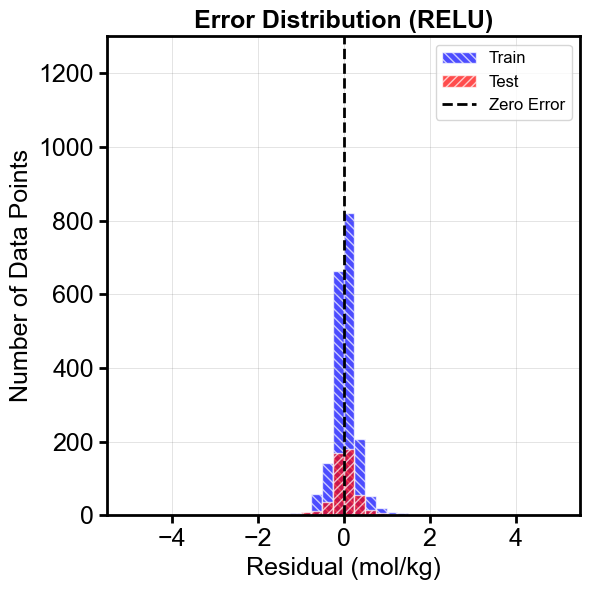

RELU 模型详细统计信息
最佳参数: {'mlp__alpha': 0.023958622242817303, 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (65, 60), 'mlp__learning_rate_init': 0.008786070599150143}
训练集R²: 0.9334
测试集R²: 0.8191
训练集MAE: 0.1967 mol/kg
测试集MAE: 0.2621 mol/kg
训练集RMSE: 0.3122 mol/kg
测试集RMSE: 0.4995 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-0.4351, 0.4623] mol/kg
测试集: 90.0% 在 [-0.5501, 0.5704] mol/kg

📊 残差统计:
训练集残差均值: 0.0259 mol/kg
测试集残差均值: 0.0344 mol/kg
训练集残差标准差: 0.3112 mol/kg
测试集残差标准差: 0.4989 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 1483/2000 数据点 (74.2%)
测试集: 350/500 数据点 (70.0%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.1080 mol/kg

生成 LOGISTIC 激活函数的可视化图表


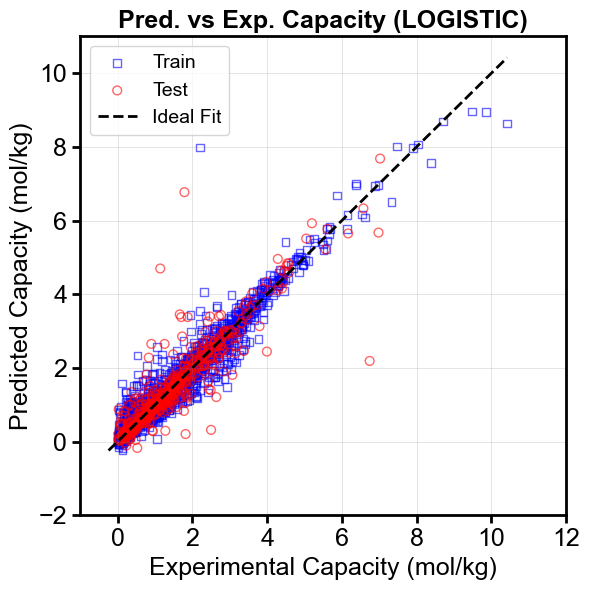

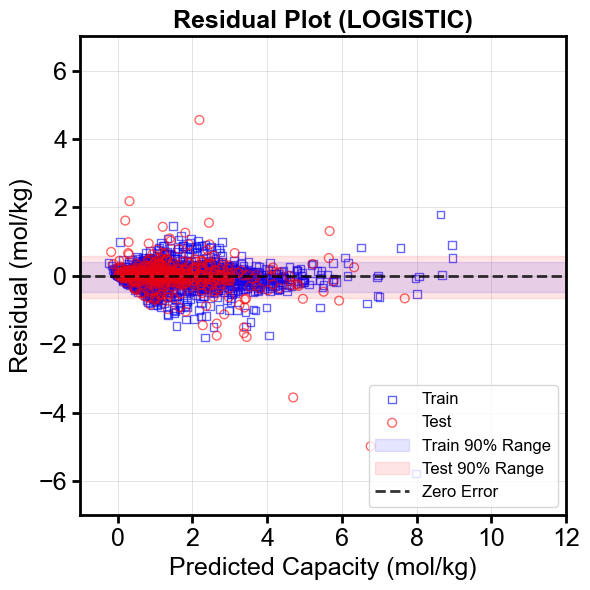

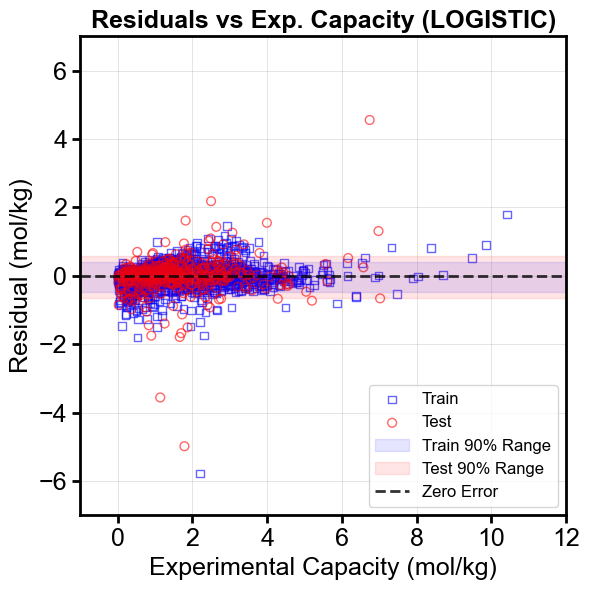

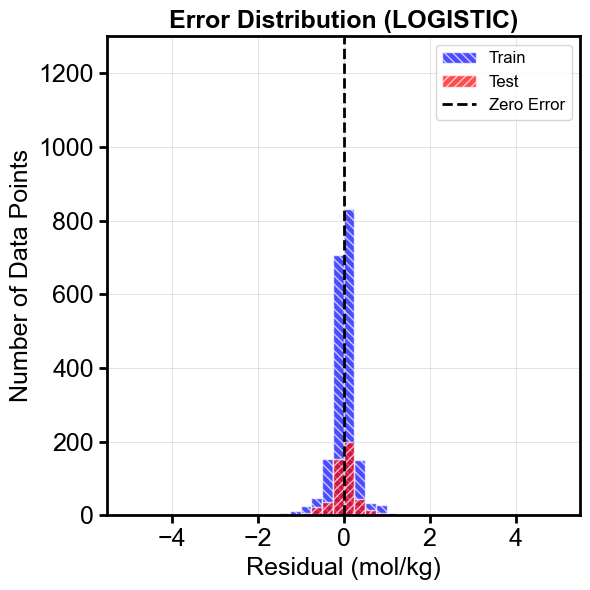

LOGISTIC 模型详细统计信息
最佳参数: {'mlp__alpha': 0.0002185548829509445, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (110, 10), 'mlp__learning_rate_init': 0.0018131243145466684}
训练集R²: 0.9301
测试集R²: 0.8084
训练集MAE: 0.1909 mol/kg
测试集MAE: 0.2633 mol/kg
训练集RMSE: 0.3198 mol/kg
测试集RMSE: 0.5140 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-0.4825, 0.4130] mol/kg
测试集: 90.0% 在 [-0.6474, 0.5864] mol/kg

📊 残差统计:
训练集残差均值: -0.0102 mol/kg
测试集残差均值: -0.0011 mol/kg
训练集残差标准差: 0.3197 mol/kg
测试集残差标准差: 0.5145 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 1538/2000 数据点 (76.9%)
测试集: 353/500 数据点 (70.6%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.1649 mol/kg

生成 TANH 激活函数的可视化图表


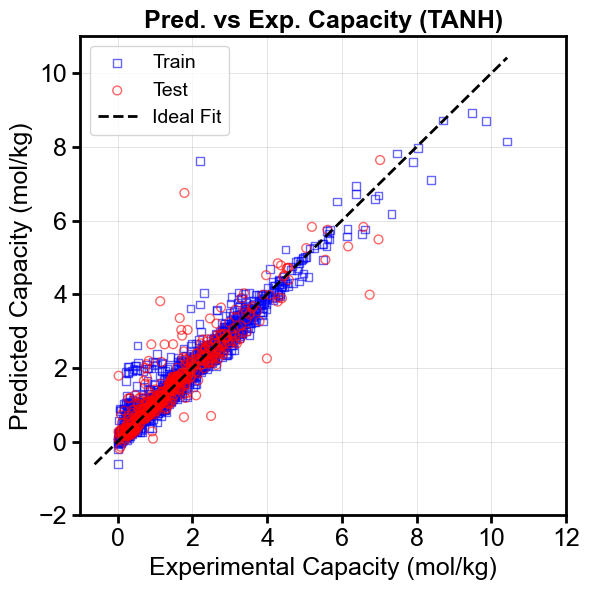

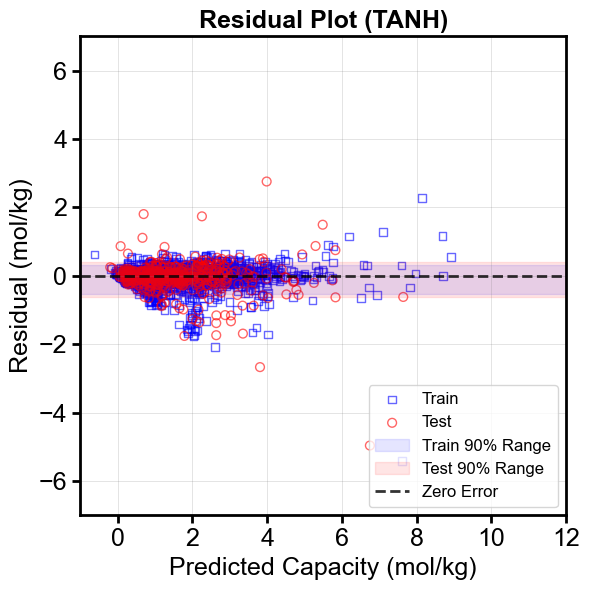

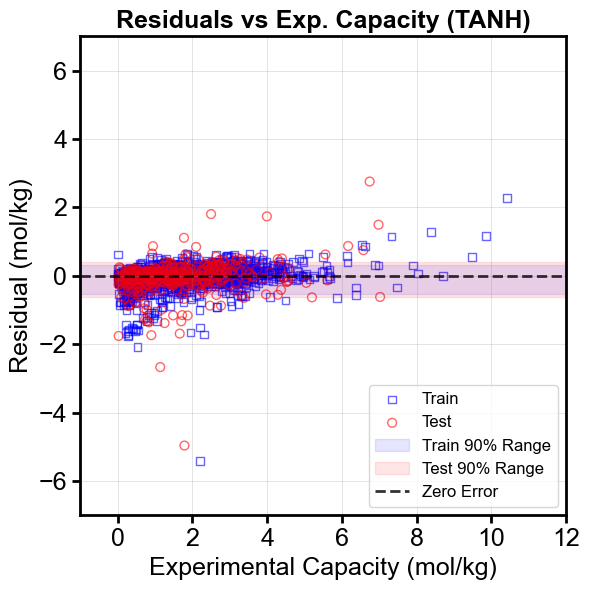

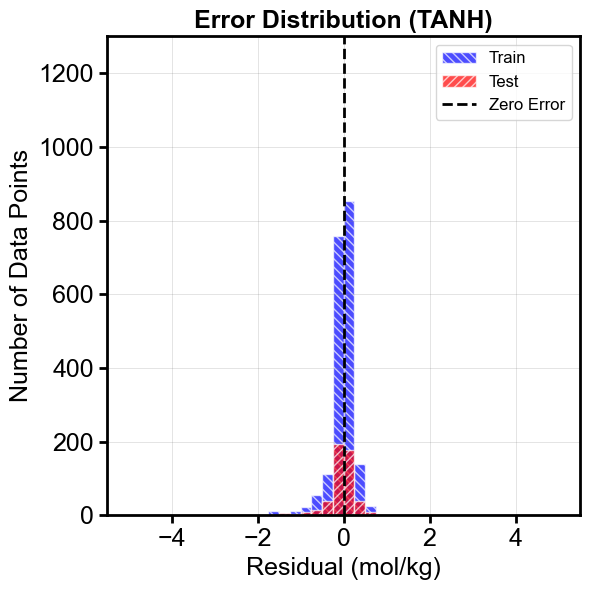

TANH 模型详细统计信息
最佳参数: {'mlp__alpha': 0.0006249958210447859, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (70, 40), 'mlp__learning_rate_init': 0.002899417963369715}
训练集R²: 0.9321
测试集R²: 0.8495
训练集MAE: 0.1807 mol/kg
测试集MAE: 0.2403 mol/kg
训练集RMSE: 0.3153 mol/kg
测试集RMSE: 0.4555 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-0.5228, 0.3300] mol/kg
测试集: 90.0% 在 [-0.6307, 0.4142] mol/kg

📊 残差统计:
训练集残差均值: -0.0304 mol/kg
测试集残差均值: -0.0493 mol/kg
训练集残差标准差: 0.3139 mol/kg
测试集残差标准差: 0.4533 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 1610/2000 数据点 (80.5%)
测试集: 369/500 数据点 (73.8%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.1080 mol/kg

生成 IDENTITY 激活函数的可视化图表


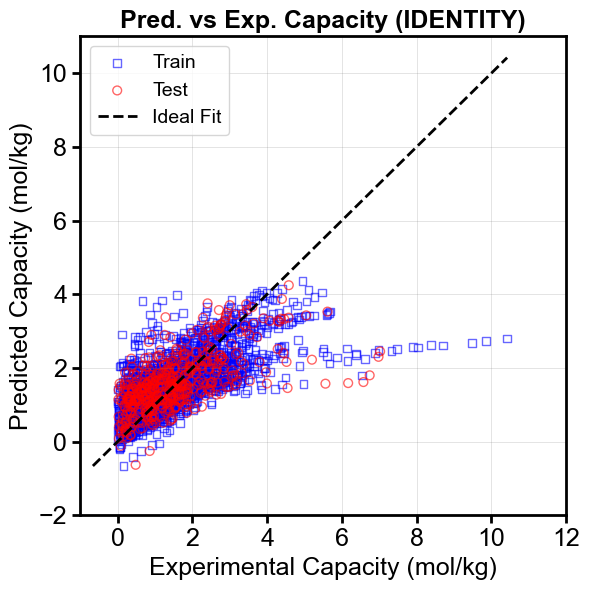

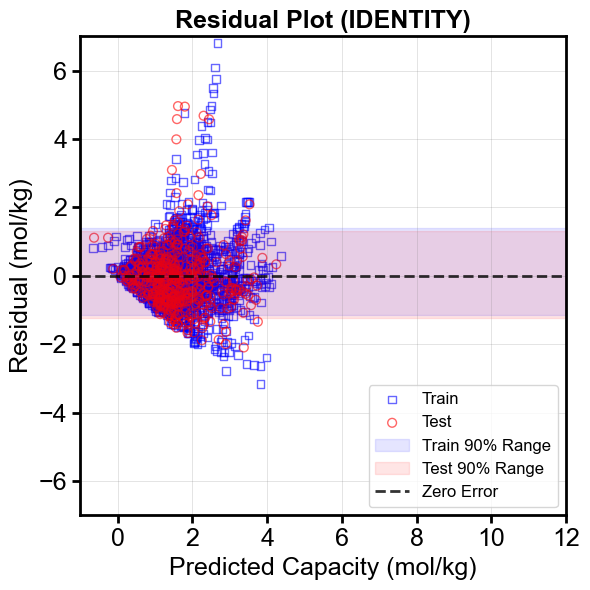

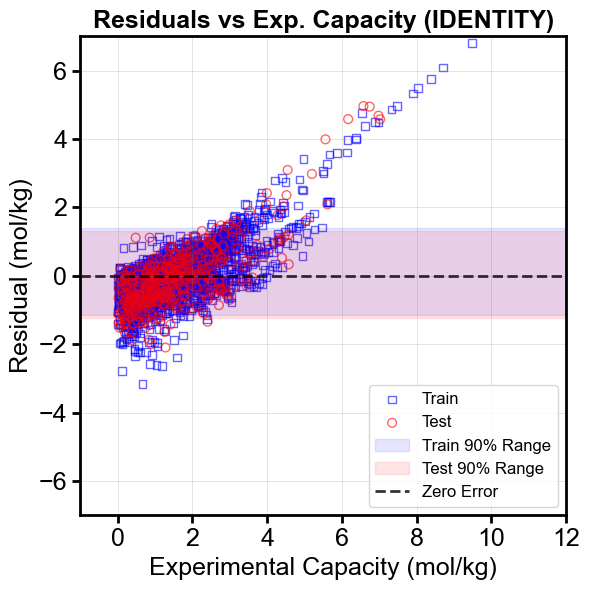

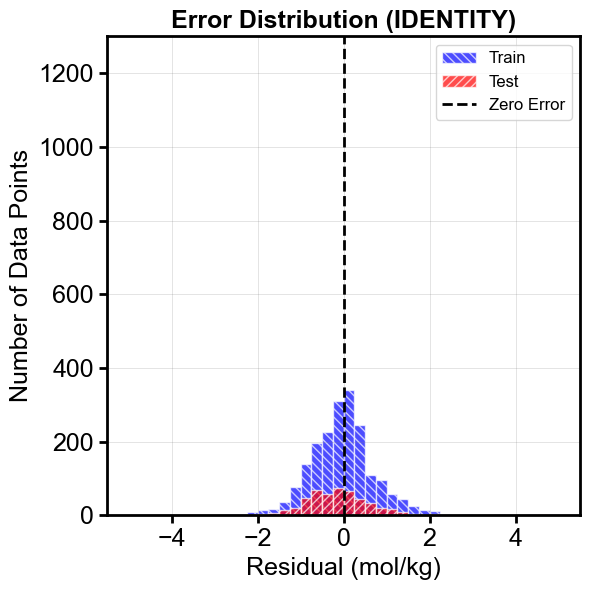

IDENTITY 模型详细统计信息
最佳参数: {'mlp__alpha': 2.6185922438658532e-05, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (105, 60), 'mlp__learning_rate_init': 0.00013974158698336442}
训练集R²: 0.4420
测试集R²: 0.3974
训练集MAE: 0.6054 mol/kg
测试集MAE: 0.6393 mol/kg
训练集RMSE: 0.9036 mol/kg
测试集RMSE: 0.9116 mol/kg

📊 残差分析 - 90%数据点范围:
训练集: 90.0% 在 [-1.1487, 1.3982] mol/kg
测试集: 90.0% 在 [-1.2453, 1.3121] mol/kg

📊 残差统计:
训练集残差均值: 0.0161 mol/kg
测试集残差均值: -0.0475 mol/kg
训练集残差标准差: 0.9037 mol/kg
测试集残差标准差: 0.9113 mol/kg

📊 误差在[-0.25, 0.25]范围内:
训练集: 648/2000 数据点 (32.4%)
测试集: 139/500 数据点 (27.8%)

📊 模型性能评估:
❌ 需要改进: 预测误差较大
过拟合程度: 0.0860 mol/kg

MLP模型训练和评估完成！


In [24]:
# 8. 定义可视化评估函数
def calculate_90_percent_range(errors):
    """计算90%数据点落入的残差范围"""
    lower_bound = np.percentile(errors, 5)
    upper_bound = np.percentile(errors, 95)
    in_range = np.sum((errors >= lower_bound) & (errors <= upper_bound))
    total = len(errors)
    percentage = (in_range / total) * 100
    return lower_bound, upper_bound, percentage

def plot_mlp_evaluation(activation_name, model_info, X_train, y_train, X_test, y_test, best_params):
    """为每个激活函数模型生成四种可视化图表"""
    
    # 获取预测值
    y_train_pred = model_info['predictions']['y_train_pred']
    y_test_pred = model_info['predictions']['y_test_pred']
    
    # 计算误差
    train_errors = y_train - y_train_pred
    test_errors = y_test - y_test_pred
    
    # 计算90%范围
    train_lower, train_upper, train_percentage = calculate_90_percent_range(train_errors)
    test_lower, test_upper, test_percentage = calculate_90_percent_range(test_errors)
    
    # 计算误差在[-0.25, 0.25]范围内的百分比
    def calculate_error_in_range(errors, lower_bound, upper_bound):
        in_range = np.sum((errors >= lower_bound) & (errors <= upper_bound))
        percentage = (in_range / len(errors)) * 100
        return in_range, percentage
    
    train_in_025, train_percent_025 = calculate_error_in_range(train_errors, -0.25, 0.25)
    test_in_025, test_percent_025 = calculate_error_in_range(test_errors, -0.25, 0.25)
    
    # 设置全局样式参数
    border_width = 2.0
    tick_fontsize = 14
    label_fontsize = 16
    title_fontsize = 18
    tick_width = 2.0
    tick_length = 6
    
    # 1. 预测值与真实值对比图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    plt.scatter(y_train, y_train_pred, color='none', edgecolor='blue', 
               alpha=0.6, s=30, label="Train", linewidth=1, marker='s')
    plt.scatter(y_test, y_test_pred, color='none', edgecolor='red', 
               alpha=0.6, s=40, label="Test", linewidth=1, marker='o')
    
    min_val = min(min(y_train), min(y_test), min(y_train_pred), min(y_test_pred))
    max_val = max(max(y_train), max(y_test), max(y_train_pred), max(y_test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='black', 
             linestyle='--', linewidth=2, label='Ideal Fit')
    
    plt.ylim(-2, 11)
    plt.xlim(-1, 12)
    
    plt.xlabel("Experimental Capacity (mol/kg)", fontsize=18, fontname='Arial')
    plt.ylabel("Predicted Capacity (mol/kg)", fontsize=18, fontname='Arial')
    plt.title(f"Pred. vs Exp. Capacity ({activation_name.upper()})", fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='upper left', prop={'family': 'Arial', 'size': 14})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontname='Arial', fontsize=18)
    plt.yticks(fontname='Arial', fontsize=18)
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 2. 残差 vs 预测值图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    plt.scatter(y_train_pred, train_errors, alpha=0.6, s=30, color='none', 
                edgecolor='blue', linewidth=1, label='Train', marker='s')
    plt.scatter(y_test_pred, test_errors, alpha=0.6, s=40, color='none', 
                edgecolor='red', linewidth=1, label='Test', marker='o')
    
    plt.axhspan(train_lower, train_upper, alpha=0.1, color='blue', label='Train 90% Range')
    plt.axhspan(test_lower, test_upper, alpha=0.1, color='red', label='Test 90% Range')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Zero Error')
    
    plt.ylim(-7, 7)
    plt.xlim(-1, 12)
    
    plt.xlabel('Predicted Capacity (mol/kg)', fontsize=18, fontname='Arial')
    plt.ylabel('Residual (mol/kg)', fontsize=18, fontname='Arial')
    plt.title(f'Residual Plot ({activation_name.upper()})', fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='lower right', prop={'family': 'Arial', 'size': 12})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontname='Arial', fontsize=18)
    plt.yticks(fontname='Arial', fontsize=18)
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 3. 残差 vs 实验值图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    plt.scatter(y_train, train_errors, alpha=0.6, s=30, color='none', 
                edgecolor='blue', linewidth=1, label='Train', marker='s')
    plt.scatter(y_test, test_errors, alpha=0.6, s=40, color='none', 
                edgecolor='red', linewidth=1, label='Test', marker='o')
    
    plt.axhspan(train_lower, train_upper, alpha=0.1, color='blue', label='Train 90% Range')
    plt.axhspan(test_lower, test_upper, alpha=0.1, color='red', label='Test 90% Range')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Zero Error')
    
    plt.ylim(-7, 7)
    plt.xlim(-1, 12)
    
    plt.xlabel('Experimental Capacity (mol/kg)', fontsize=18, fontname='Arial')
    plt.ylabel('Residual (mol/kg)', fontsize=18, fontname='Arial')
    plt.title(f'Residuals vs Exp. Capacity ({activation_name.upper()})', fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='lower right', prop={'family': 'Arial', 'size': 12})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontname='Arial', fontsize=18)
    plt.yticks(fontname='Arial', fontsize=18)
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 4. 误差分布图
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(border_width)
        spine.set_color('black')
    
    # 按照0.25为间隔的区间划分
    bin_edges = []
    current = 0
    max_error = max(np.abs(train_errors.max()), np.abs(test_errors.max()))
    
    while current <= max_error + 0.25:
        bin_edges.extend([-current - 0.25, -current])
        if current != 0:
            bin_edges.extend([current, current + 0.25])
        current += 0.25
    
    bin_edges = sorted(set(bin_edges))
    
    plt.hist(train_errors, bins=bin_edges, alpha=0.7, color='blue', 
             edgecolor='white', label='Train', density=False, hatch='\\\\\\\\')
    plt.hist(test_errors, bins=bin_edges, alpha=0.7, color='red', 
             edgecolor='white', label='Test', density=False, hatch='////')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
    
    plt.ylim(0, 1300)
    plt.xlim(-5.5, 5.5)
    
    plt.xlabel('Residual (mol/kg)', fontsize=18, fontname='Arial')
    plt.ylabel('Number of Data Points', fontsize=18, fontname='Arial')
    plt.title(f'Error Distribution ({activation_name.upper()})', fontsize=title_fontsize, fontweight='bold', fontname='Arial')
    plt.legend(loc='upper right', prop={'family': 'Arial', 'size': 12})
    
    plt.tick_params(axis='x', which='major', width=tick_width, length=tick_length, 
                   color='black', labelcolor='black', bottom=True, top=False)
    plt.tick_params(axis='y', which='major', width=tick_width, length=tick_length,
                   color='black', labelcolor='black', left=True, right=False)
    
    plt.xticks(fontname='Arial', fontsize=18)
    plt.yticks(fontname='Arial', fontsize=18)
    
    plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # 打印详细的统计信息
    print("="*80)
    print(f"{activation_name.upper()} 模型详细统计信息")
    print("="*80)
    
    train_metrics = model_info['train_metrics']
    test_metrics = model_info['test_metrics']
    
    print(f"最佳参数: {best_params}")
    print(f"训练集R²: {train_metrics['R2']:.4f}")
    print(f"测试集R²: {test_metrics['R2']:.4f}")
    print(f"训练集MAE: {train_metrics['MAE']:.4f} mol/kg")
    print(f"测试集MAE: {test_metrics['MAE']:.4f} mol/kg")
    print(f"训练集RMSE: {train_metrics['RMSE']:.4f} mol/kg")
    print(f"测试集RMSE: {test_metrics['RMSE']:.4f} mol/kg")
    
    print(f"\n📊 残差分析 - 90%数据点范围:")
    print(f"训练集: {train_percentage:.1f}% 在 [{train_lower:.4f}, {train_upper:.4f}] mol/kg")
    print(f"测试集: {test_percentage:.1f}% 在 [{test_lower:.4f}, {test_upper:.4f}] mol/kg")
    
    print(f"\n📊 残差统计:")
    print(f"训练集残差均值: {train_errors.mean():.4f} mol/kg")
    print(f"测试集残差均值: {test_errors.mean():.4f} mol/kg")
    print(f"训练集残差标准差: {train_errors.std():.4f} mol/kg")
    print(f"测试集残差标准差: {test_errors.std():.4f} mol/kg")
    
    print(f"\n📊 误差在[-0.25, 0.25]范围内:")
    print(f"训练集: {train_in_025}/{len(train_errors)} 数据点 ({train_percent_025:.1f}%)")
    print(f"测试集: {test_in_025}/{len(test_errors)} 数据点 ({test_percent_025:.1f}%)")
    
    print(f"\n📊 模型性能评估:")
    max_train_error = max(abs(train_lower), abs(train_upper))
    max_test_error = max(abs(test_lower), abs(test_upper))
    
    if max_test_error < 0.1:
        print("✅ 优秀: 90%预测误差 < 0.1 mol/kg")
    elif max_test_error < 0.2:
        print("👍 良好: 90%预测误差 < 0.2 mol/kg")
    elif max_test_error < 0.3:
        print("⚠️ 一般: 90%预测误差 < 0.3 mol/kg")
    else:
        print("❌ 需要改进: 预测误差较大")
    
    print(f"过拟合程度: {abs(max_train_error - max_test_error):.4f} mol/kg")

# 9. 为每个激活函数生成可视化图表
if results:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS FOR EACH ACTIVATION FUNCTION")
    print("="*80)
    
    for activation_name, model_info in results.items():
        print(f"\n{'='*80}")
        print(f"生成 {activation_name.upper()} 激活函数的可视化图表")
        print(f"{'='*80}")
        
        plot_mlp_evaluation(
            activation_name=activation_name,
            model_info=model_info,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            best_params=model_info['best_params']
        )

print("\nMLP模型训练和评估完成！")


PREDICTION RESULTS FOR ALL MODELS

RELU 预测结果统计:
训练集样本数: 2000
测试集样本数: 500
训练集平均绝对误差: 0.1967
测试集平均绝对误差: 0.2621

LOGISTIC 预测结果统计:
训练集样本数: 2000
测试集样本数: 500
训练集平均绝对误差: 0.1909
测试集平均绝对误差: 0.2633

TANH 预测结果统计:
训练集样本数: 2000
测试集样本数: 500
训练集平均绝对误差: 0.1807
测试集平均绝对误差: 0.2403

IDENTITY 预测结果统计:
训练集样本数: 2000
测试集样本数: 500
训练集平均绝对误差: 0.6054
测试集平均绝对误差: 0.6393

前20行预测结果:
   Activation Dataset  True_y  Predicted_y  Absolute_Error  Relative_Error
0        relu   Train  9.8530       8.9160          0.9370          9.5094
1        relu   Train  1.9806       2.5265          0.5459         27.5615
2        relu   Train  1.5088       1.4621          0.0467          3.0949
3        relu   Train  0.2609       0.3708          0.1099         42.1389
4        relu   Train  0.1360       0.0470          0.0890         65.4343
5        relu   Train  1.8511       1.9610          0.1099          5.9364
6        relu   Train  1.3384       1.4578          0.1194          8.9204
7        relu   Train  2.4500       2.3823    

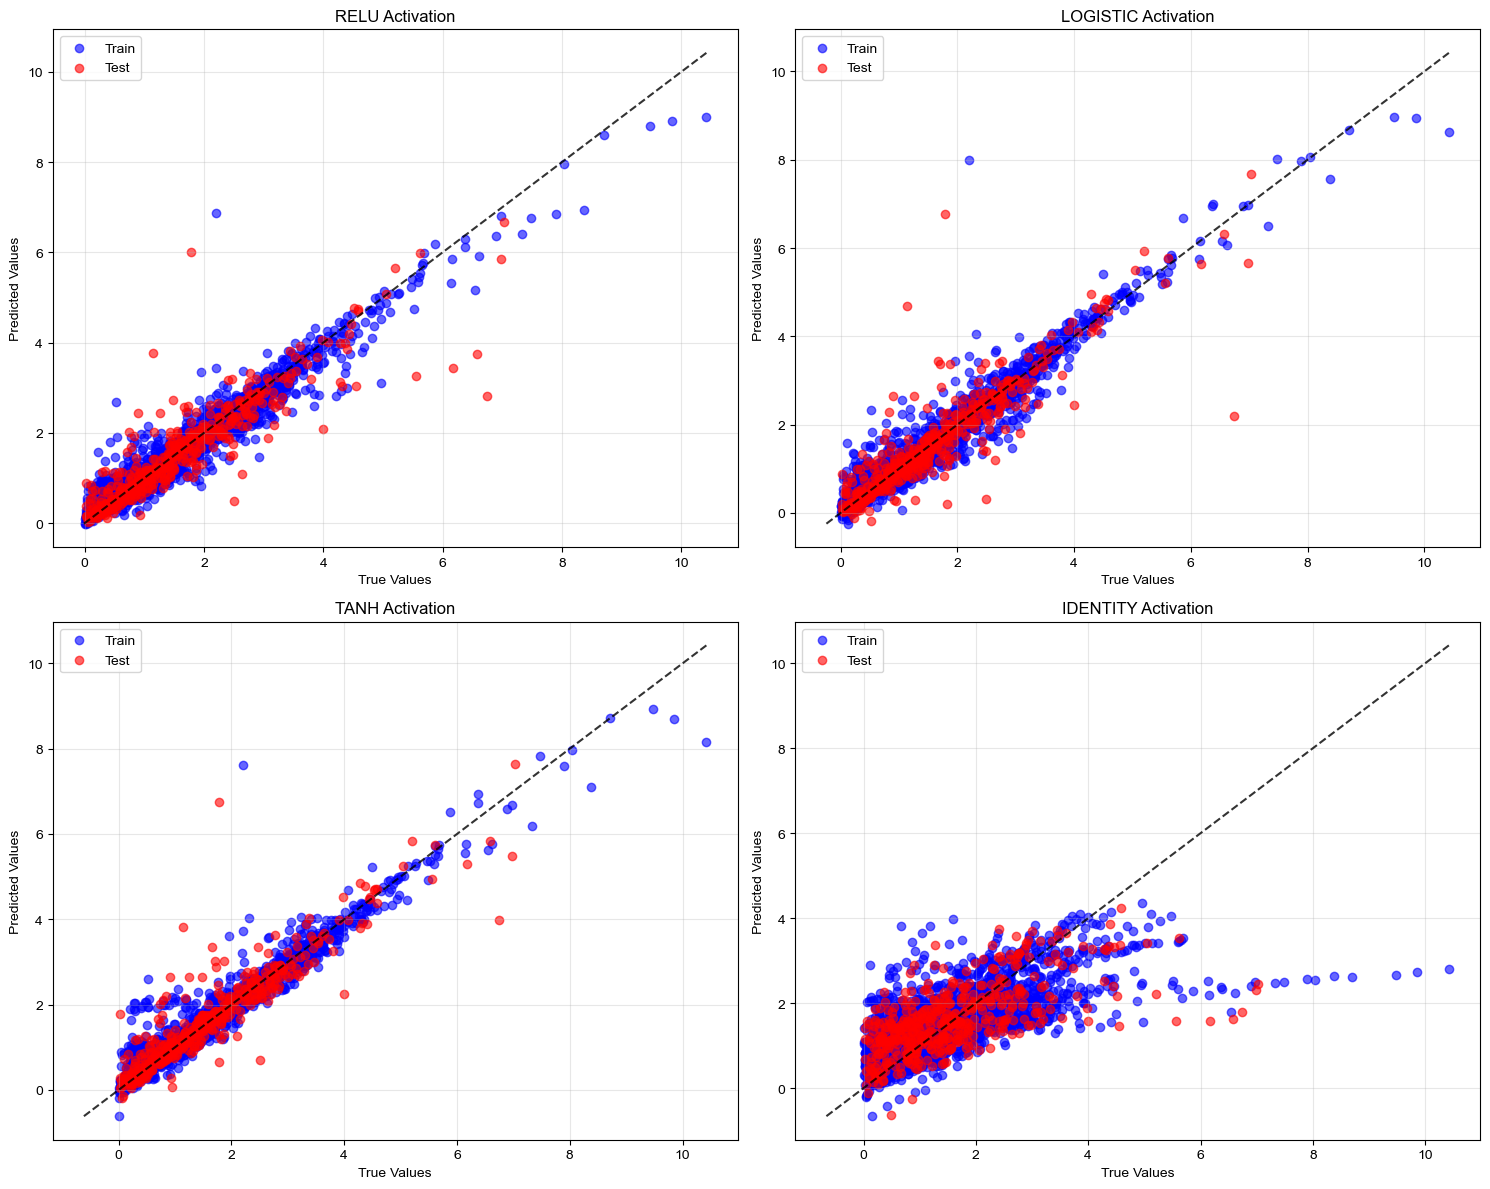


最佳模型: TANH 激活函数
测试集R2: 0.8495
测试集RMSE: 0.4555
最佳模型已保存为 'E:\RNZhang\CO2 capacity\修改\MLP修改_four activation_no early stopping - 副本\best_model_tanh.pkl'


In [30]:
# 6. 输出所有模型的预测结果
print("\n" + "="*80)
print("PREDICTION RESULTS FOR ALL MODELS")
print("="*80)

# 创建DataFrame来存储所有预测结果
all_predictions = []

for activation_name, res in results.items():
    # 获取训练集和测试集的预测结果
    y_train_pred = res['predictions']['y_train_pred']
    y_test_pred = res['predictions']['y_test_pred']
    
    # 创建训练集预测结果DataFrame
    train_df = pd.DataFrame({
        'Activation': activation_name,
        'Dataset': 'Train',
        'True_y': y_train,
        'Predicted_y': y_train_pred,
        'Absolute_Error': np.abs(y_train - y_train_pred),
        'Relative_Error': np.abs((y_train - y_train_pred) / np.clip(np.abs(y_train), 1e-10, None)) * 100
    })
    
    # 创建测试集预测结果DataFrame
    test_df = pd.DataFrame({
        'Activation': activation_name,
        'Dataset': 'Test',
        'True_y': y_test,
        'Predicted_y': y_test_pred,
        'Absolute_Error': np.abs(y_test - y_test_pred),
        'Relative_Error': np.abs((y_test - y_test_pred) / np.clip(np.abs(y_test), 1e-10, None)) * 100
    })
    
    # 合并训练集和测试集结果
    activation_df = pd.concat([train_df, test_df], ignore_index=True)
    all_predictions.append(activation_df)
    
    # 输出每个激活函数的预测结果统计
    print(f"\n{activation_name.upper()} 预测结果统计:")
    print(f"训练集样本数: {len(y_train)}")
    print(f"测试集样本数: {len(y_test)}")
    print(f"训练集平均绝对误差: {np.mean(np.abs(y_train - y_train_pred)):.4f}")
    print(f"测试集平均绝对误差: {np.mean(np.abs(y_test - y_test_pred)):.4f}")

# 合并所有激活函数的预测结果
all_predictions_df = pd.concat(all_predictions, ignore_index=True)

# 输出前20行预测结果
print("\n前20行预测结果:")
print(all_predictions_df.head(20).round(4))

# 按激活函数和数据集分组统计
print("\n按激活函数和数据集分组的预测误差统计:")
grouped_stats = all_predictions_df.groupby(['Activation', 'Dataset']).agg({
    'Absolute_Error': ['mean', 'std', 'min', 'max'],
    'Relative_Error': ['mean', 'std', 'min', 'max']
}).round(4)
print(grouped_stats)

# 保存预测结果到CSV文件
import os
import joblib

# 保存预测结果到CSV文件（保存到.ipynb所在目录）
csv_filename = 'all_model_predictions.csv'
all_predictions_df.to_csv(csv_filename, index=False)

# 获取完整的绝对路径并显示
csv_absolute_path = os.path.abspath(csv_filename)
print(f"\n所有预测结果已保存到 '{csv_absolute_path}'")


# 7. 可选：可视化预测结果
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, activation_name in enumerate(activations):
    if activation_name in results:
        # 获取该激活函数的预测结果
        activation_data = all_predictions_df[all_predictions_df['Activation'] == activation_name]
        
        # 分离训练集和测试集
        train_data = activation_data[activation_data['Dataset'] == 'Train']
        test_data = activation_data[activation_data['Dataset'] == 'Test']
        
        # 绘制散点图
        axes[i].scatter(train_data['True_y'], train_data['Predicted_y'], 
                       alpha=0.6, label='Train', c='blue')
        axes[i].scatter(test_data['True_y'], test_data['Predicted_y'], 
                       alpha=0.6, label='Test', c='red')
        
        # 添加理想预测线
        min_val = min(activation_data['True_y'].min(), activation_data['Predicted_y'].min())
        max_val = max(activation_data['True_y'].max(), activation_data['Predicted_y'].max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8)
        
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].set_title(f'{activation_name.upper()} Activation')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. 输出最佳模型（基于测试集R2）
best_activation = max(results.items(), key=lambda x: x[1]['test_metrics']['R2'])[0]
print(f"\n最佳模型: {best_activation.upper()} 激活函数")
print(f"测试集R2: {results[best_activation]['test_metrics']['R2']:.4f}")
print(f"测试集RMSE: {results[best_activation]['test_metrics']['RMSE']:.4f}")

# 保存最佳模型（保存到.ipynb所在目录）
best_model_filename = f'best_model_{best_activation}.pkl'
joblib.dump(results[best_activation]['best_model'], best_model_filename)

# 获取完整的绝对路径并显示
model_absolute_path = os.path.abspath(best_model_filename)
print(f"最佳模型已保存为 '{model_absolute_path}'")

In [33]:
# 获取训练集和测试集的原始索引
train_indices = X_train.index  # 训练集的原始索引
test_indices = X_test.index    # 测试集的原始索引

# 从原始数据中获取对应的No.和IL
train_no = data.loc[train_indices, 'No.'].values
train_il = data.loc[train_indices, 'IL'].values
test_no = data.loc[test_indices, 'No.'].values
test_il = data.loc[test_indices, 'IL'].values

all_predictions = []

for kernel_name, res in results.items():
    print(f"为 {kernel_name} 计算预测结果...")
    best_model = res['best_model']
    
    # 计算训练集和测试集的预测
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # 创建训练集预测结果DataFrame
    train_df = pd.DataFrame({
        'No.': train_no,
        'IL': train_il,
        'Kernel': kernel_name,
        'Dataset': 'Train',
        'True_y': y_train.values,
        'Predicted_y': y_train_pred,
        'Absolute_Error': np.abs(y_train.values - y_train_pred),
        'Relative_Error_%': np.abs((y_train.values - y_train_pred) / np.clip(np.abs(y_train.values), 1e-10, None)) * 100
    })
    
    # 创建测试集预测结果DataFrame
    test_df = pd.DataFrame({
        'No.': test_no,
        'IL': test_il,
        'Kernel': kernel_name,
        'Dataset': 'Test',
        'True_y': y_test.values,
        'Predicted_y': y_test_pred,
        'Absolute_Error': np.abs(y_test.values - y_test_pred),
        'Relative_Error_%': np.abs((y_test.values - y_test_pred) / np.clip(np.abs(y_test.values), 1e-10, None)) * 100
    })
    
    # 合并训练集和测试集结果
    kernel_df = pd.concat([train_df, test_df], ignore_index=True)
    all_predictions.append(kernel_df)

# 合并所有核函数的预测结果
all_predictions_df = pd.concat(all_predictions, ignore_index=True)

# 按No.排序
all_predictions_df = all_predictions_df.sort_values(['No.', 'Kernel', 'Dataset']).reset_index(drop=True)

# 保存预测结果到CSV文件
csv_filename = 'all_model_predictions_with_ids.csv'
all_predictions_df.to_csv(csv_filename, index=False)

print(f"\n所有预测结果已保存到 '{csv_filename}'")
print(f"文件包含以下列: {list(all_predictions_df.columns)}")



为 relu 计算预测结果...
为 logistic 计算预测结果...
为 tanh 计算预测结果...
为 identity 计算预测结果...

所有预测结果已保存到 'all_model_predictions_with_ids.csv'
文件包含以下列: ['No.', 'IL', 'Kernel', 'Dataset', 'True_y', 'Predicted_y', 'Absolute_Error', 'Relative_Error_%']
示例数据:


In [ ]:
#### 代码完